In [16]:
import numpy as np
import cv2, os, glob, time, random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib import cm
import warnings

warnings.filterwarnings('ignore')

### Data ###

In [17]:
car_imgs = glob.glob("data/vehicles/*/*.*")
notcar_imgs = glob.glob("data/non-vehicles/*/*.*")

In [18]:
def data_info(images, display=None) :
    print("Number of images : ", len(images))
    example_img = mpimg.imread(images[0])
    print("Image shape : ", example_img.shape)
    print("Image data type : ", example_img.dtype)
    if display is not None :
        nrows,ncols = display
        n_imgs = nrows*ncols
        images_select = random.sample(images, n_imgs)
        fig, axes = plt.subplots(nrows,ncols, figsize=(2*ncols,2*nrows))
        for img,ax in zip(images_select, axes.flatten()) :
            img = mpimg.imread(img)
            ax.imshow(img)
            ax.axis('off')

**Vehicles**

Number of images :  8792
Image shape :  (64, 64, 3)
Image data type :  float32


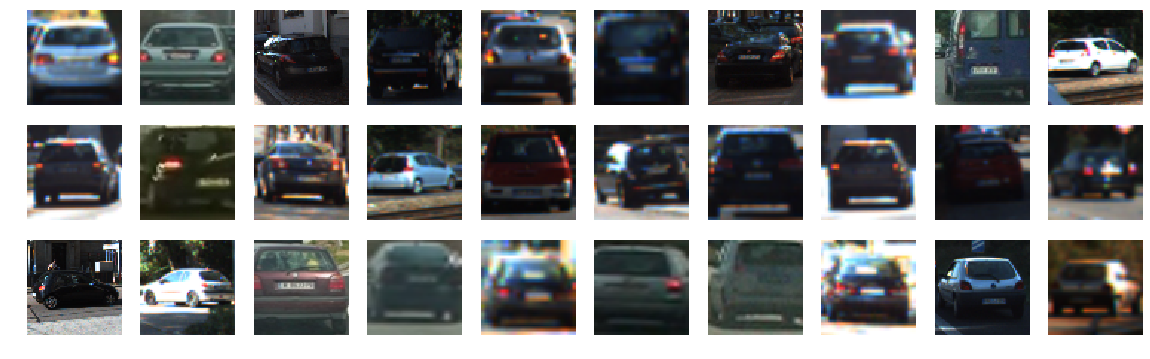

In [19]:
data_info(car_imgs, display=(3,10))

**non-vehicles**

Number of images :  8968
Image shape :  (64, 64, 3)
Image data type :  float32


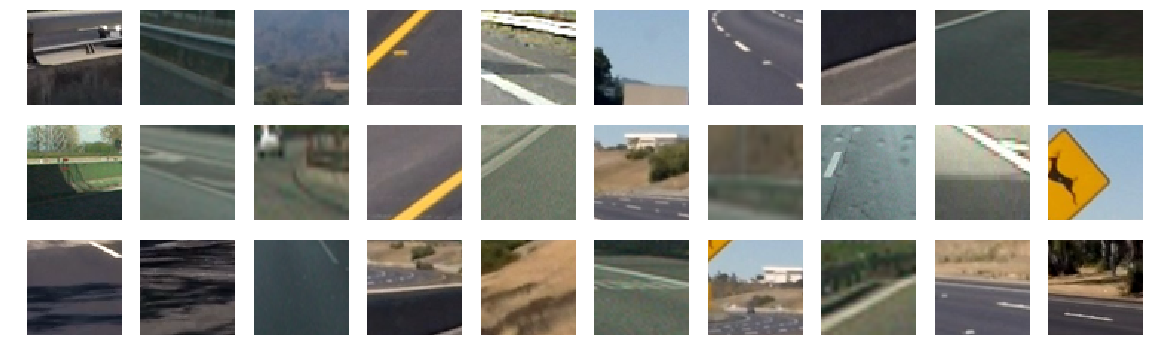

In [20]:
data_info(notcar_imgs, display=(3,10))

### Train-test splitting

In [23]:
from sklearn.model_selection import train_test_split

# split vehicles data by selecting tracks manually for GTI data and randomly for KITTI data
car_train_indices = []
car_test_indices = []

def split_manual(DIR, indices):
    start,stop = indices
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    for f in img_files :
        index = int(f.split("image")[1][:4])
        if start<=index<=stop :
            car_test_indices.append(car_imgs.index(f))
        else :
            car_train_indices.append(car_imgs.index(f))
            
def split_random(DIR, test_size=0.2) :
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    train,test = train_test_split(img_files, test_size=test_size, random_state=0)
    car_train_indices.extend([car_imgs.index(f) for f in train])
    car_test_indices.extend([car_imgs.index(f) for f in test])

split_manual("data/vehicles\\GTI_Far/", (605,799))
split_manual("data/vehicles\\GTI_Left/", (9,183))
split_manual("data/vehicles\\GTI_Far/", (191,397))
split_manual("data/vehicles\\GTI_Far/", (803,974))
test_size = 1/(1+len(car_train_indices)/len(car_test_indices))
split_random("data/vehicles\\KITTI_extracted/", test_size=test_size)
print("Number of images in vehicles training set : ", len(car_train_indices))
print("Number of images in vehicles test set : ", len(car_test_indices))
print("Test size is {:2.2f}% of total vehicles dataset".format(
        100/(1+len(car_train_indices)/len(car_test_indices))))
print("="*50)

# split non-vehicles data through random split
img_files = glob.glob(os.path.join("data/non-vehicles/*/*.*"))
notcar_train_indices, notcar_test_indices = train_test_split(range(len(notcar_imgs)), test_size=test_size,
                                                            random_state=0)
print("Number of images in non-vehicles training set : ", len(notcar_train_indices))
print("Number of images in non-vehicles test set : ", len(notcar_test_indices))
print("Test size is {:2.2f}% of total non-vehicles dataset".format(100/(1+len(notcar_train_indices))))

Number of images in vehicles training set :  7540
Number of images in vehicles test set :  1837
Test size is 19.59% of total vehicles dataset
Number of images in non-vehicles training set :  7211
Number of images in non-vehicles test set :  1757
Test size is 0.01% of total non-vehicles dataset


In [24]:
# dictionaries for exploring colorpsaces
cvtColor = {"RGB"  : cv2.COLOR_BGR2RGB, 
            "LUV"  : cv2.COLOR_BGR2LUV, 
            "YUV"  : cv2.COLOR_BGR2YUV,
            "HSV"  : cv2.COLOR_BGR2HSV,
            "HLS"  : cv2.COLOR_BGR2HLS,
            "YCrCb": cv2.COLOR_BGR2YCrCb}

# set range for color channels
histRange = {"RGB"  : [(0,256)]*3,
             "YCrCb": [(0,256)]*3,
             "YUV"  : [(0,256)]*3,
             "HSV"  : [(0,256)]*3,
             "HLS"  : [(0,256)]*3,
             "LUV"  : [(0,192),(0,256),(0,256)]}


# functions for changing between opencv format (BGR) and the default (RGB)
def BGR2RGB(img) :
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def RGB2BGR(img) :
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

### Histogram of Oriented Gradients (HOG)

In [25]:
from skimage.feature import hog

# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [26]:
def hog_features_visualize(data, channels=["R","G","B"], orient=9,
                          pix_per_cell = 8, cell_per_block = 2, hog_channel = "ALL") :
    cvt_color = cvtColor["".join(channels)]
    bins_range = histRange["".join(channels)]
    imgs = random.sample(data,3)
    fig, axes = plt.subplots(3,4,figsize=(15,12))
    for ax in axes.flatten() :
        ax.axis('off')
    for img,ax in zip(imgs,axes) :
        image = cv2.imread(img)
        ax[0].imshow(BGR2RGB(image))
        image = cv2.cvtColor(image, cvt_color)
        for i in range(image.shape[2]) :
            channel = np.maximum(image[:,:,i],0)
            features, hog_image = get_hog_features(channel, orient, pix_per_cell, 
                                            cell_per_block, vis=True, feature_vec=False)
            ax[i+1].imshow(hog_image)
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(channels[i]+' channel hog')

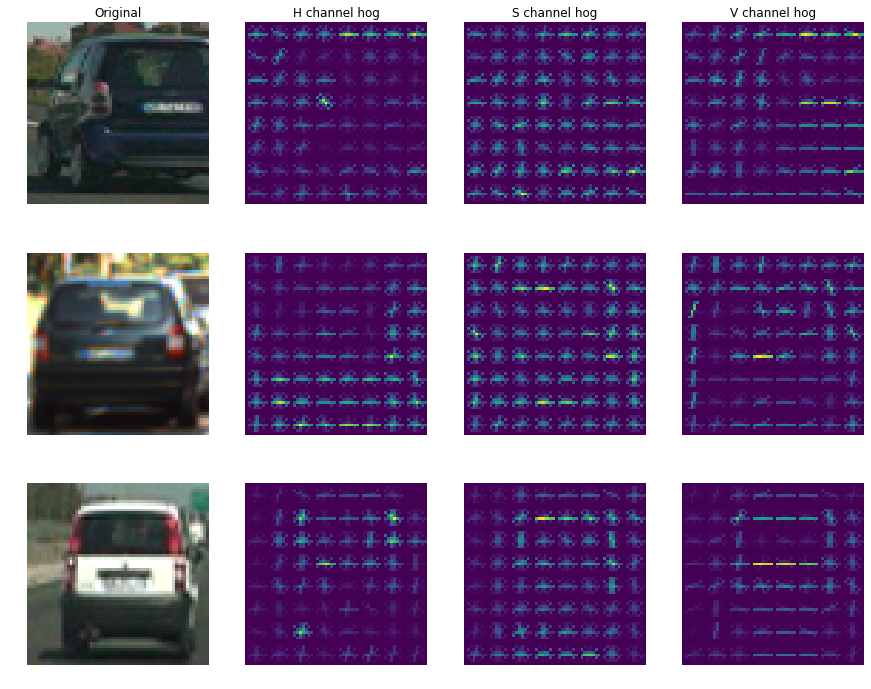

In [27]:
data = car_imgs
channels = ["H","S","V"]
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hog_features_visualize(data, channels, orient, pix_per_cell, 
                       cell_per_block, hog_channel)

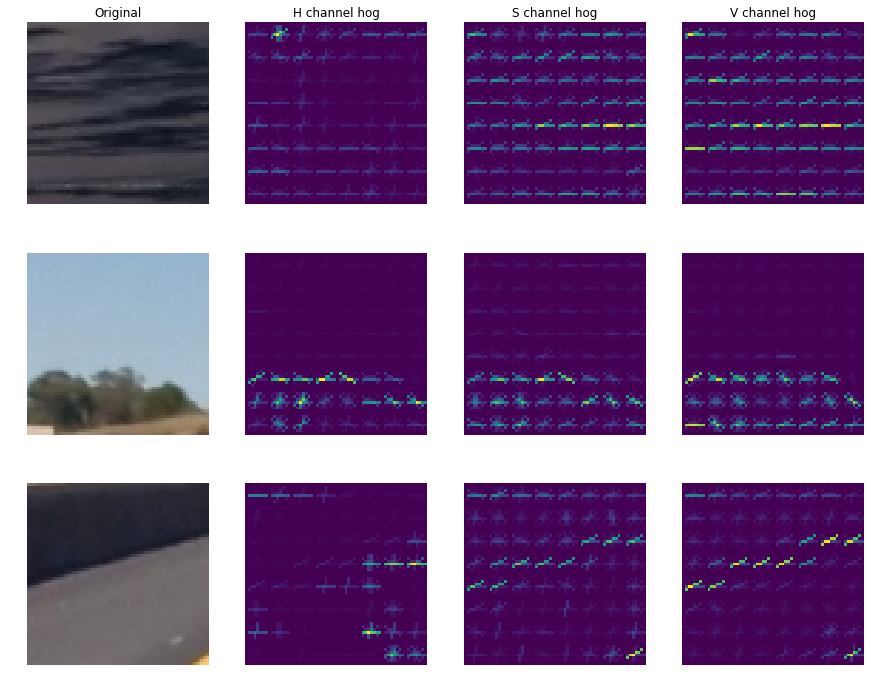

In [28]:
data = notcar_imgs
channels = ["H","S","V"]
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hog_features_visualize(data, channels, orient, pix_per_cell, 
                       cell_per_block, hog_channel)

Given that we have 64x64 images, a grid size of 8x8 and 2 cells per block seems like a reasonable choice and amounts to 196 features per color channel per orientation. 

### SVM

In [29]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# function to extract features from a list of images
def extract_features(imgs, cvt_color, orient, pix_per_cell, 
                     cell_per_block, hog_channel):
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = cv2.cvtColor(image, cvt_color)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    return np.array(features)

def SVC_hog(cvt_color=cvtColor["RGB"], orient=9, pix_per_cell=8, cell_per_block=2, 
            hog_channel="ALL", debug=True) :
    t=time.time()
    car_features = extract_features(car_imgs, cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcar_features = extract_features(notcar_imgs, cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors and normalize
    X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices], 
                         notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    if debug :
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        sample = random.sample(range(len(y_test)), n_predict)
        print('My SVC predicts: ', svc.predict(X_test[sample]))
        print('For these',n_predict, 'labels: ', y_test[sample])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Check linear SVC sample timings and test predictions :

In [30]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # options : 0,1,2,"ALL"
cvt_color = cvtColor["YUV"]

SVC_hog(cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, hog_channel=hog_channel, debug=True)

78.7 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
12.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9958
My SVC predicts:  [0. 0. 1. 0. 0. 0. 1. 0. 1. 1.]
For these 10 labels:  [0. 0. 1. 0. 0. 0. 1. 0. 1. 1.]
0.00102 Seconds to predict 10 labels with SVC


Quantify the differences for different colorspaces:

In [72]:
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" # options : 0,1,2,"ALL"

for color_space in cvtColor :
    print("="*50)
    print("Color space : ", color_space)
    SVC_hog(cvt_color=cvtColor[color_space], orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, hog_channel=hog_channel, debug=False)

Color space :  RGB
Test Accuracy of SVC =  0.9789
Color space :  LUV
Test Accuracy of SVC =  0.9925
Color space :  YUV
Test Accuracy of SVC =  0.9958
Color space :  HSV
Test Accuracy of SVC =  0.9914
Color space :  HLS
Test Accuracy of SVC =  0.9933
Color space :  YCrCb
Test Accuracy of SVC =  0.9953


**YCrCb colorspace** gives highest score.  

Find the optimal number of orientations bins:

In [74]:
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" # options : 0,1,2,"ALL"
cvt_color=cvtColor["YCrCb"]

for orient in [8,9,10,11] :
        print("="*50)
        print("Orientation bins : ", orient)
        SVC_hog(cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, hog_channel=hog_channel, debug=False)

Orientation bins :  8
Test Accuracy of SVC =  0.9925
Orientation bins :  9
Test Accuracy of SVC =  0.9953
Orientation bins :  10
Test Accuracy of SVC =  0.9953
Orientation bins :  11
Test Accuracy of SVC =  0.995


Optimal **number of orientation bins = 10**

---

### Color histogram features and Spatial features

In [31]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features

Plot color histograms using HSV colorspace for vehicles and non-vehicles datasets using 32 bins:

In [32]:
def color_features_visualize(data, channels=["R","G","B"], nbins=32) :
    cvt_color = cvtColor["".join(channels)]
    bins_range = histRange["".join(channels)]
    imgs = random.sample(data,3)
    fig, axes = plt.subplots(3,4,figsize=(16,8))
    for img,ax in zip(imgs,axes) :
        image = cv2.imread(img)
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        image = cv2.cvtColor(image, cvt_color)
        bins_range = bins_range
        nbins=nbins
        channel_hist, bin_edges, hist_features = color_hist(image, nbins=nbins, 
                                                bins_range=bins_range, visualize=True)
        width=[(b[1]-b[0]) for b in bin_edges]
        for i in range(len(channel_hist)):
            ax[i+1].bar(bin_edges[i][:-1],channel_hist[i],width=width[i])
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(channels[i]+' channel histogram')

def bin_features_visualize(data, nbins=32) :
    cvt_color = cvtColor["".join(channels)]
    bins_range = histRange["".join(channels)]
    imgs = random.sample(data,3)
    fig, axes = plt.subplots(3,4,figsize=(16,8))
    for img,ax in zip(imgs,axes) :
        image = cv2.imread(img)
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        image = cv2.cvtColor(image, cvt_color)
        bins_range = bins_range
        nbins=nbins
        channel_hist, bin_edges, hist_features = color_hist(image, nbins=nbins, 
                                                bins_range=bins_range, visualize=True)
        width=[(b[1]-b[0]) for b in bin_edges]
        for i in range(len(channel_hist)):
            ax[i+1].bar(bin_edges[i][:-1],channel_hist[i],width=width[i])
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(channels[i]+' channel histogram')

**vehicles : **

In [33]:
data = car_imgs
channels = ["H","S","V"]
nbins=32

color_features_visualize(data, channels, nbins)

**non-vehicles : **

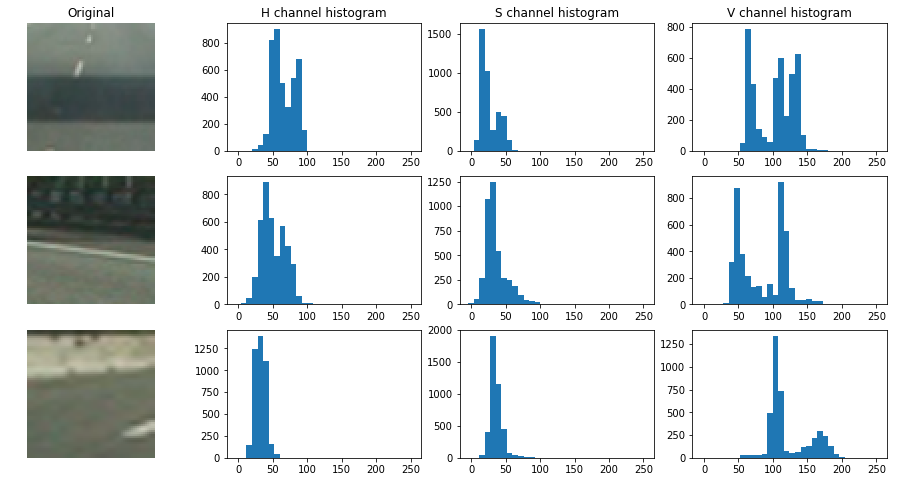

In [34]:
data = notcar_imgs
channels = ["H","S","V"]
nbins=32

color_features_visualize(data, channels, nbins)

There are two other parameters : number of spatial bins and number of histogram bins. 

Find the optimal parameters:

In [35]:
# function to extract features from a list of images
def extract_features(imgs, cvt_color, spatial_size, hist_bins, hist_range):
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        color_feature_image = cv2.cvtColor(image, cvt_color)   
        spatial_features = bin_spatial(color_feature_image, size=spatial_size)
        hist_features = color_hist(color_feature_image, nbins=hist_bins, bins_range=hist_range)
        # combine all features
        features.append(np.concatenate((spatial_features, hist_features)))
    return np.array(features)


def SVC_color(cvt_color=cvtColor['RGB'], spatial=32, histbin=32, hist_range=[(0, 256)]*3, debug=True) :
    t = time.time()
    car_features = extract_features(car_imgs, cvt_color=cvt_color, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range)
    notcar_features = extract_features(notcar_imgs, cvt_color=cvt_color, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=hist_range)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract color features...')
    
    X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices], 
                         notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using : ', spatial, ' spatial bins and ', histbin,' histogram bins')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    if debug :
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        sample = random.sample(range(len(y_test )), n_predict)
        print('My SVC predicts: ', svc.predict(X_test[sample]))
        print('For these',n_predict, 'labels: ', y_test[sample])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [36]:
spatial = 32
histbin = 32

for color_space in cvtColor :
    print("="*50)
    print("Color space : ", color_space)
    SVC_color(cvt_color=cvtColor[color_space], spatial=spatial, histbin=histbin, 
              hist_range=histRange[color_space], debug=False)

Color space :  RGB
Test Accuracy of SVC =  0.9686
Color space :  LUV
Test Accuracy of SVC =  0.9638
Color space :  YUV
Test Accuracy of SVC =  0.9677
Color space :  HSV
Test Accuracy of SVC =  0.9708
Color space :  HLS
Test Accuracy of SVC =  0.9591
Color space :  YCrCb
Test Accuracy of SVC =  0.9677


Color space = HSV

In [37]:
cvt_color = cvtColor["HSV"]
hist_range = histRange["HSV"]

for spatial in [8,16,32] :
    for histbin in [16,32,64] :
        print("="*50)
        print("Number of spatial bins : ", spatial)
        print("Number of color histogram bins : ", histbin)
        SVC_color(cvt_color=cvt_color, spatial=spatial, histbin=histbin, 
                  hist_range=hist_range, debug=False)

Number of spatial bins :  8
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9655
Number of spatial bins :  8
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9736
Number of spatial bins :  8
Number of color histogram bins :  64
Test Accuracy of SVC =  0.9708
Number of spatial bins :  16
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9558
Number of spatial bins :  16
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9677
Number of spatial bins :  16
Number of color histogram bins :  64
Test Accuracy of SVC =  0.9738
Number of spatial bins :  32
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9622
Number of spatial bins :  32
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9708
Number of spatial bins :  32
Number of color histogram bins :  64
Test Accuracy of SVC =  0.9752


Number of spatial bins = 32 and number of color histogram bins = 64

---

### Summarize

* *colorspace = YCrCb*
* *orientations = 10*
* *pixels per cell = (8,8)*
* *cells per block = (2,2)*
* *color histogram bins = 64 per color channel*  
* *spatial bins = (32,32)*

For the combined feature vector. YCrCb still gives the best overall test scores.

In [38]:
from skimage.feature import hog


# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    #bin_centers = (bin_edges[1:]  + bin_edges[:-1])/2
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features

# function to extract features from a list of images
def extract_features(imgs):
    # parameters
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    color="YCrCb"
    cvt_color = cvtColor[color]
    bins_range = histRange[color]
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = cv2.cvtColor(image, cvt_color)
        # HOG features
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
        # spatial and color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=bins_range)
        # combine all features
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return np.array(features)

Cross-validation is used to determine the penalty parameter 'C' in the linear SVM classifier : 

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


t=time.time()
car_features = extract_features(car_imgs)
notcar_features = extract_features(notcar_imgs)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract all features...')
# Create an array stack of feature vectors and normalize
X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = np.vstack((car_features[car_test_indices], 
                     notcar_features[notcar_test_indices])).astype(np.float64) 
X_test = standard_scaler.transform(X_test) # use same fit as training data

# labels vector
y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

print('Feature vector length:', len(X_train[0]))

clf = GridSearchCV(LinearSVC(), param_grid={'C':np.logspace(-3,-2,5)})
# Check the training time for the SVC
t=time.time()
clf = clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print("CV results : ", clf.best_estimator_)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
sample = random.sample(range(len(y_test)), n_predict)
print('My SVC predicts: ', clf.predict(X_test[sample]))
print('For these',n_predict, 'labels: ', y_test[sample])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

83.84 Seconds to extract all features...
Feature vector length: 9144
152.12 Seconds to train SVC...
CV results :  LinearSVC(C=0.005623413251903491, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
Test Accuracy of SVC =  0.9969
My SVC predicts:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
For these 10 labels:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
0.01008 Seconds to predict 10 labels with SVC


### Sliding window

Use 4 scales, each with their own search area :

| Scale			| y-range		|
| ------------- |---------------|
|  1.0			| (380,508)		|
|  1.5  		| (380,572)		| 
|  2.0  		| (380,636)		| 
|  2.5 			| (380,700)		| 
where default `scale=1.0` corresponds to window size of 64x64 pixels. Note that `y=380` is approximately the horizon position.  

In [40]:
def find_cars(img, ystart, ystop, scale, clf, X_scaler):
    
    # parameters
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    color="YCrCb"
    cvt_color = cvtColor[color]
    bins_range = histRange[color] 
    
    #img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = cv2.cvtColor(img_tosearch, cvt_color)
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=bins_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,
                                                          hog_features)).reshape(1, -1))       
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,1),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list



def draw_boxes(img, bbox_list, color=(0,0,255)):
    for box in bbox_list :
        cv2.rectangle(img, box[0], box[1], color,6)
    return img
    

# sliding window scales and the search y-range
y_range = {1.0 : (380,508), 
           1.5 : (380,572), 
           2.0 : (380,636), 
           2.5 : (380,700)} 

In [41]:
# 参考文档中的exportFrames()不知道什么原因，第35张图片无法正常显示

VIDEO_PATH = './test_video.mp4'
EXTRACT_FOLDER = './main_video_frames'
EXTRACT_FREQUENCY = 1

def exportFrames(video_path, dst_folder, index):
    import cv2
    video = cv2.VideoCapture()
    if not video.open(video_path):
        print("can not open the video")
        exit(1)
    count = 1
    while True:
        _, frame = video.read()
        if frame is None:
            break
        if count % EXTRACT_FREQUENCY == 0:
            save_path = "{}/frame{:>04d}.jpg".format(dst_folder, index)
            cv2.imwrite(save_path, frame)
            index += 1
        count += 1
    video.release()
    # print all pics
    print("Totally save {:d} pics".format(index-1))

# delete the dir
import shutil
try:
    shutil.rmtree(EXTRACT_FOLDER)
except OSError:
    pass
import os
os.mkdir(EXTRACT_FOLDER)
exportFrames(VIDEO_PATH, EXTRACT_FOLDER, 1)

Totally save 35 pics


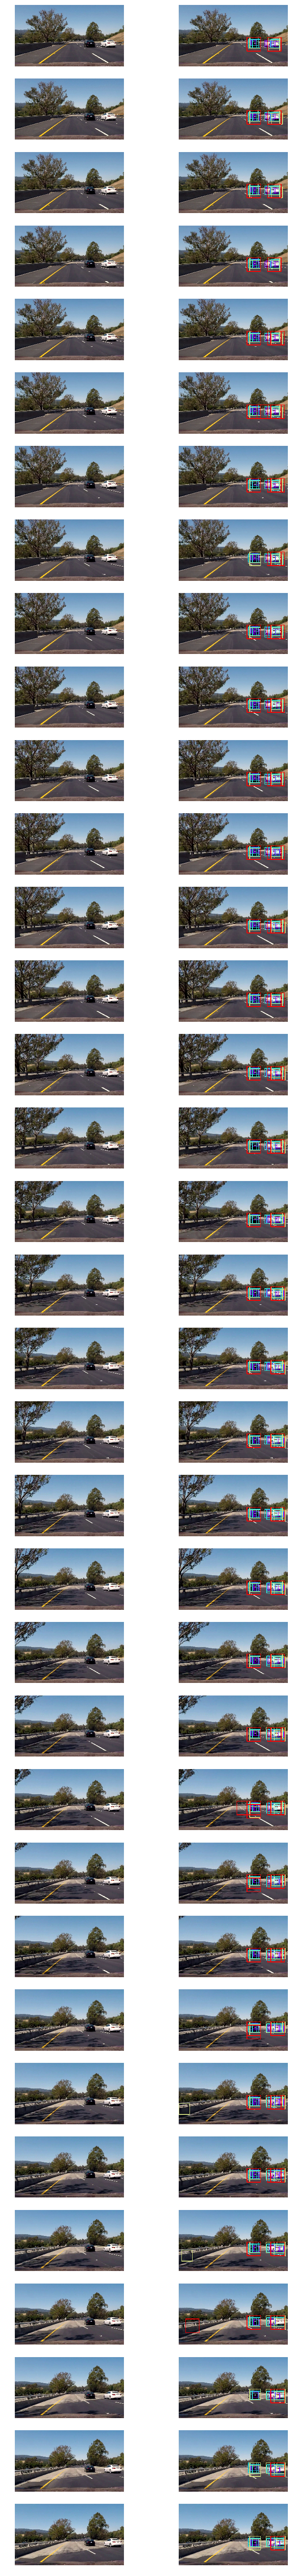

In [42]:

test_imgs = glob.glob("main_video_frames/*.jpg")
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    out_img = np.copy(BGR2RGB(img))
    ax[0].imshow(BGR2RGB(img))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,4)) :
        ystart,ystop = y_range[scale]
        color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
    ax[1].imshow(out_img)

### Heatmaps

In [43]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    return img

In [44]:
from scipy.ndimage.measurements import label


test_imgs = glob.glob("main_video_frames/*.jpg")
nrows = len(test_imgs)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    out_img = np.copy(BGR2RGB(img))
    ax[0].imshow(BGR2RGB(img))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
        ystart,ystop = y_range[scale]
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
        heat = add_heat(heat,bbox_list)
    ax[1].imshow(heat, cmap=plt.cm.inferno)
    heat = apply_threshold(heat,2)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(BGR2RGB(img)), labels)
    ax[2].imshow(draw_img)

### Video Output Func

In [45]:
video_dim = (1280, 720)

class vehicle_detection :
    def __init__(self, n_iter=25, n_update=2, threshold=8) :
        self.count = 0
        # bboxes for every frame
        self.out_img = None
        # labeled bboxes 
        self.out_img_labeled = None
        # vehicle labels 
        self.labels = [None,0]
        # list of bbox lists from last n iterations
        self.bbox_list_n = [] 
        # number of frames to smooth over
        self.n_iter = n_iter
        # number of frames after which to update detection
        self.n_update = n_update
        # threshold for heat map
        self.threshold = threshold
        # heat map
        self.heat = np.zeros(video_dim[::-1])
        self.heatmap = np.copy(self.heat)
    
    def process_image(self, image) :
        self.count += 1
        self.image=image
        out_img = np.copy(image)
        img = RGB2BGR(image)
        for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
            ystart,ystop = y_range[scale]
            bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
            color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
            self.out_img = draw_boxes(out_img, bbox_list,color)
        self.bbox_list_n.append(bbox_list)
        if self.count%self.n_update == 0 :
            for bbox_list in self.bbox_list_n :
                self.heat = add_heat(self.heat,bbox_list)
            self.heat = apply_threshold(self.heat,self.threshold)
            self.heatmap = np.clip(self.heat, 0, 255)
            self.labels = label(self.heatmap)
            self.heat = np.clip(self.labels[0],0,1)*2
        if len(self.bbox_list_n)>self.n_iter :
            self.bbox_list_n.pop(0)
        self.out_img_labeled = draw_labeled_bboxes(np.copy(image), self.labels)
        return self.out_display()
    

    def out_display(self) :
        imgA = cv2.resize(self.out_img, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        imgB = np.uint8(self.heatmap*255/(0.001+np.max(self.heatmap)))
        imgB = cm.inferno(imgB)[:,:,:3]*255
        imgB = imgB.astype(np.uint8)
        imgB = cv2.addWeighted(imgB, 1, self.image, 0.4, 0)
        imgB = cv2.resize(imgB, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        hA,wA = imgA.shape[:2]
        h_text = int(video_dim[1]/2-hA)
        textA = np.zeros((h_text, wA,3), dtype=np.uint8)
        textB = np.zeros((video_dim[1]-h_text-2*hA, wA,3), dtype=np.uint8)
        textA[:,:,1] = 200
        textB[:,:,1] = 200
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(textA,'Bounding boxes',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        cv2.putText(textB,'Heatmap',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        img_combined_right = np.vstack((textA,imgA,textB,imgB))
        return np.hstack((self.out_img_labeled, img_combined_right))

---

### Final video output

In [48]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vd = vehicle_detection()
output = './project_video.mp4'
clip = VideoFileClip("./test_video.mp4")
clip = clip.fl_image(vd.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Imageio: 'ffmpeg-win32-v3.2.4.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-win32-v3.2.4.exe (34.1 MB)


Downloading: 8192/35749888 bytes (0.0180224/35749888 bytes (0.5327680/35749888 bytes (0.9409600/35749888 bytes (1.1557056/35749888 bytes (1.6671744/35749888 bytes (1.9770048/35749888 bytes (2.2909312/35749888 bytes (2.5999424/35749888 bytes (2.81114112/35749888 bytes (3.1%1212416/35749888 bytes (3.4%1327104/35749888 bytes (3.7%1458176/35749888 bytes (4.1%1556480/35749888 bytes (4.4%1654784/35749888 bytes (4.6%1769472/35749888 bytes (4.9%1900544/35749888 bytes (5.3%2031616/35749888 bytes (5.7%2129920/35749888 bytes (6.0%2228224/35749888 bytes (6.2%2351104/35749888 bytes (6.6%2441216/35749888 bytes (6.8%2539520/35749888 bytes (7.1%2670592/35749888 bytes (7.5%2768896/35749888 bytes (7.7%2883584/35749888 bytes (8.1%2957312/35749888 bytes (8.3%3039232/35749888 bytes (8.5%3137536/35749888 bytes (8.8%3276800/35749888 bytes (9.2%3407872/35749888 bytes (9.5%3506176/35749888 bytes (9.8%3588096/35749888 bytes (10.03686400/35749888 bytes (10.33825664/35749888 bytes (10.73932160/35749888 bytes (11.

30818304/35749888 bytes (86.2%30916608/35749888 bytes (86.5%31031296/35749888 bytes (86.8%31129600/35749888 bytes (87.1%31244288/35749888 bytes (87.4%31358976/35749888 bytes (87.7%31457280/35749888 bytes (88.0%31588352/35749888 bytes (88.4%31703040/35749888 bytes (88.7%31817728/35749888 bytes (89.0%31916032/35749888 bytes (89.3%32014336/35749888 bytes (89.6%32145408/35749888 bytes (89.9%32260096/35749888 bytes (90.2%32342016/35749888 bytes (90.5%32440320/35749888 bytes (90.7%32555008/35749888 bytes (91.1%32694272/35749888 bytes (91.5%32808960/35749888 bytes (91.8%32899072/35749888 bytes (92.0%33005568/35749888 bytes (92.3%33112064/35749888 bytes (92.6%33226752/35749888 bytes (92.9%33325056/35749888 bytes (93.2%33423360/35749888 bytes (93.5%33538048/35749888 bytes (93.8%33660928/35749888 bytes (94.2%33751040/35749888 bytes (94.4%33865728/35749888 bytes (94.7%33947648/35749888 bytes (95.0%34045952/35749888 bytes (95.2%34177024/35749888 bytes (95.6%34258944/35749888 bytes (95.8%34390016/

 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:37<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video.mp4 

Wall time: 39.9 s


# PreLab TensorFlow 

Epoch: 0050 cost= 0.130492195 W= 0.37899986 b= -0.12947255
Epoch: 0100 cost= 0.124306709 W= 0.37130338 b= -0.07410527
Epoch: 0150 cost= 0.118835732 W= 0.36406472 b= -0.022030905
Epoch: 0200 cost= 0.113996729 W= 0.35725662 b= 0.026946403
Epoch: 0250 cost= 0.109716818 W= 0.3508534 b= 0.073010705
Epoch: 0300 cost= 0.105931357 W= 0.344831 b= 0.11633549
Epoch: 0350 cost= 0.102583304 W= 0.33916682 b= 0.15708351
Epoch: 0400 cost= 0.099622153 W= 0.33383942 b= 0.19540794
Epoch: 0450 cost= 0.097003192 W= 0.32882896 b= 0.23145299
Epoch: 0500 cost= 0.094686925 W= 0.3241165 b= 0.2653542
Epoch: 0550 cost= 0.092638306 W= 0.31968418 b= 0.29723987
Epoch: 0600 cost= 0.090826549 W= 0.31551555 b= 0.32722846
Epoch: 0650 cost= 0.089224204 W= 0.31159487 b= 0.35543367
Epoch: 0700 cost= 0.087807149 W= 0.30790728 b= 0.3819615
Epoch: 0750 cost= 0.086553924 W= 0.30443916 b= 0.40691158
Epoch: 0800 cost= 0.085445672 W= 0.30117726 b= 0.43037722
Epoch: 0850 cost= 0.084465548 W= 0.2981092 b= 0.4524482
Epoch: 0900 cost

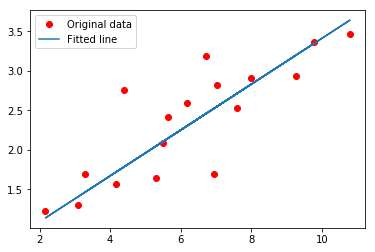

Testing... (Mean square loss Comparison)
Testing cost= 0.07685403
Absolute mean square loss difference: 0.0053005666


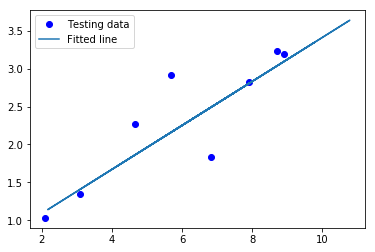

In [3]:
'''
A linear regression learning algorithm example using TensorFlow library.

'''

from __future__ import print_function

import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
rng = numpy.random

# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50

# Training Data
train_X = numpy.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = numpy.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]

# tf Graph Input
X = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights
W = tf.Variable(rng.randn(), name="weight")
b = tf.Variable(rng.randn(), name="bias")

# Construct a linear model
pred = tf.add(tf.multiply(X, W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
#  Note, minimize() knows to modify W and b because Variable objects are trainable=True by default
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (x, y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={X: x, Y: y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(W), "b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(W), "b=", sess.run(b), '\n')

    # Graphic display
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()

    # Testing example, as requested (Issue #2)
    test_X = numpy.asarray([6.83, 4.668, 8.9, 7.91, 5.7, 8.7, 3.1, 2.1])
    test_Y = numpy.asarray([1.84, 2.273, 3.2, 2.831, 2.92, 3.24, 1.35, 1.03])

    print("Testing... (Mean square loss Comparison)")
    testing_cost = sess.run(
        tf.reduce_sum(tf.pow(pred - Y, 2)) / (2 * test_X.shape[0]),
        feed_dict={X: test_X, Y: test_Y})  # same function as cost above
    print("Testing cost=", testing_cost)
    print("Absolute mean square loss difference:", abs(
        training_cost - testing_cost))

    plt.plot(test_X, test_Y, 'bo', label='Testing data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()
